# Cluster Activities on Baseline Thresholds for Acceleration and Angular Velocity

Each trial of stimulated activity is presented as a time series of sensor data collected over a 10, 30, or 60 second interval. As a prelimary method to process this data, the maximum value from every trial will be taken as a potential threshold to represent that particular activity. By clustering on these values, we hope to identify potential threshold acceleration and angular velocity values that discriminates a fall from an ADL.

In future analyses, different processing methods should be attempted to preserve more data from the experimental trials as this approach discards all of the sensor measurements besides the max value.

In [270]:
import datetime
import pandas as pd
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [217]:
# Load Data
rawData = pd.read_csv('https://raw.githubusercontent.com/mjwolfe91/MSDS_Capstone_JC_AN_MW/master/Data/HAR_FALL-UP_CompleteDataSet.csv')

# Extract Wrist Sensor Data (Angular/Accelerometer) from each trial for every subject
# 17 subjects * 11 activities (ADL/Falls) * 3 trials = 561 trials
# Sensors set at sampling rate of ~18.4 Hz (18-20 Hz)
raw_WristSensor = rawData[['TimeStamps','WristAccelerometer', 'Unnamed: 30', 'Unnamed: 31', 'WristAngularVelocity', 'Unnamed: 33', 'Unnamed: 34','Subject', 'Activity', 'Trial']]
# Rename Columns
raw_WristSensor.rename(columns = {'TimeStamps':'TimeStamp', 'WristAccelerometer': 'Accelerometer (x)', 'Unnamed: 30':'Accelerometer (y)','Unnamed: 31':'Accelerometer (z)', 'WristAngularVelocity': 'Angular Velocity (x)', 'Unnamed: 33':'Angular Velocity (y)','Unnamed: 34':'Angular Velocity (z)'}, inplace = True)
# Change data types 
raw_WristSensor.TimeStamp = pd.to_datetime(raw_WristSensor.TimeStamp)
for col in ['Accelerometer (x)','Accelerometer (y)','Accelerometer (z)','Angular Velocity (x)','Angular Velocity (y)','Angular Velocity (z)']:
    raw_WristSensor[col] = pd.to_numeric(raw_WristSensor[1:][col])
for col in ['Subject', 'Activity', 'Trial']:
    raw_WristSensor[col] = raw_WristSensor[col].astype('category')
#raw_WristSensor.dtypes

# Magntiude of Accelerometer and Gyroscope sensors
a_mag = np.sqrt(raw_WristSensor['Accelerometer (x)']**2 + raw_WristSensor['Accelerometer (y)']**2 + raw_WristSensor['Accelerometer (z)']**2)
w_mag = np.sqrt(raw_WristSensor['Angular Velocity (x)']**2 + raw_WristSensor['Angular Velocity (y)']**2 + raw_WristSensor['Angular Velocity (z)']**2)
raw_WristSensor.insert(10, 'Acceleration Magntiude', a_mag)
raw_WristSensor.insert(11, 'Angular Velocity Magntiude', w_mag)

In [223]:
raw_WristSensor.dtypes

TimeStamp                     datetime64[ns]
Accelerometer (x)                    float64
Accelerometer (y)                    float64
Accelerometer (z)                    float64
Angular Velocity (x)                 float64
Angular Velocity (y)                 float64
Angular Velocity (z)                 float64
Subject                             category
Activity                            category
Trial                               category
Acceleration Magntiude               float64
Angular Velocity Magntiude           float64
dtype: object

In [218]:
def sortTrial(dict_,row_):
    if raw_WristSensor.Trial[i] == 1:
        dict_['T1'].append(row_)
    elif raw_WristSensor.Trial[i] == 2:
        dict_['T2'].append(row_)
    elif raw_WristSensor.Trial[i] == 3:
        dict_['T3'].append(row_)

def sortActivityTrial(dict_,row_):
    if raw_WristSensor.Activity[i] == 1:
        sortTrial(dict_['A1'],row_)
        #dict_['A1'].append(row_)
    elif raw_WristSensor.Activity[i] == 2:
        sortTrial(dict_['A2'],row_)
        #dict_['A2'].append(row_)
    elif raw_WristSensor.Activity[i] == 3:
        sortTrial(dict_['A3'],row_)
        #dict_['A3'].append(row_)
    elif raw_WristSensor.Activity[i] == 4:
        sortTrial(dict_['A4'],row_)
        #dict_['A4'].append(row_)
    elif raw_WristSensor.Activity[i] == 5:
        sortTrial(dict_['A5'],row_)
        #dict_['A5'].append(row_)
    elif raw_WristSensor.Activity[i] == 6:
        sortTrial(dict_['A6'],row_)
        #dict_['A6'].append(row_)
    elif raw_WristSensor.Activity[i] == 7:
        sortTrial(dict_['A7'],row_)
        #dict_['A7'].append(row_)
    elif raw_WristSensor.Activity[i] == 8:
        sortTrial(dict_['A8'],row_)
        #dict_['A8'].append(row_)
    elif raw_WristSensor.Activity[i] == 9:
        sortTrial(dict_['A9'],row_)
        #dict_['A9'].append(row_)
    elif raw_WristSensor.Activity[i] == 10:
        sortTrial(dict_['A10'],row_)
        #dict_['A10'].append(row_)
    elif raw_WristSensor.Activity[i] == 11:
        sortTrial(dict_['A11'],row_)
        #dict_['A11'].append(row_)

In [219]:
# Aggregate Wrist Sensor data by Subjects
WristS_Subjects = {}

for s in np.unique(raw_WristSensor.Subject[1:]):
    WristS_Subjects["S{0}".format(int(s))] = {"A1":{"T1":[],"T2":[],"T3":[]},"A2":{"T1":[],"T2":[],"T3":[]},"A3":{"T1":[],"T2":[],"T3":[]},"A4":{"T1":[],"T2":[],"T3":[]},"A5":{"T1":[],"T2":[],"T3":[]}, "A6":{"T1":[],"T2":[],"T3":[]},
                                              "A7":{"T1":[],"T2":[],"T3":[]},"A8":{"T1":[],"T2":[],"T3":[]},"A9":{"T1":[],"T2":[],"T3":[]},"A10":{"T1":[],"T2":[],"T3":[]},"A11":{"T1":[],"T2":[],"T3":[]}}


for i, row in raw_WristSensor[1:].iterrows():
    if raw_WristSensor.Subject[i] == 1:
        sortActivityTrial(WristS_Subjects['S1'],row)
    elif raw_WristSensor.Subject[i] == 2:
        sortActivityTrial(WristS_Subjects['S2'],row)
    elif raw_WristSensor.Subject[i] == 3:
        sortActivityTrial(WristS_Subjects['S3'],row)
    elif raw_WristSensor.Subject[i] == 4:
        sortActivityTrial(WristS_Subjects['S4'],row)
    elif raw_WristSensor.Subject[i] == 5:
        sortActivityTrial(WristS_Subjects['S5'],row)
    elif raw_WristSensor.Subject[i] == 6:
        sortActivityTrial(WristS_Subjects['S6'],row)
    elif raw_WristSensor.Subject[i] == 7:
        sortActivityTrial(WristS_Subjects['S7'],row)
    elif raw_WristSensor.Subject[i] == 8:
        sortActivityTrial(WristS_Subjects['S8'],row)
    elif raw_WristSensor.Subject[i] == 9:
        sortActivityTrial(WristS_Subjects['S9'],row)
    elif raw_WristSensor.Subject[i] == 10:
        sortActivityTrial(WristS_Subjects['S10'],row)
    elif raw_WristSensor.Subject[i] == 11:
        sortActivityTrial(WristS_Subjects['S11'],row)
    elif raw_WristSensor.Subject[i] == 12:
        sortActivityTrial(WristS_Subjects['S12'],row)
    elif raw_WristSensor.Subject[i] == 13:
        sortActivityTrial(WristS_Subjects['S13'],row)
    elif raw_WristSensor.Subject[i] == 14:
        sortActivityTrial(WristS_Subjects['S14'],row)
    elif raw_WristSensor.Subject[i] == 15:
        sortActivityTrial(WristS_Subjects['S15'],row)
    elif raw_WristSensor.Subject[i] == 16:
        sortActivityTrial(WristS_Subjects['S16'],row)
    elif raw_WristSensor.Subject[i] == 17:
        sortActivityTrial(WristS_Subjects['S17'],row)

# Change lists to numpy array
# Column idx of numpy array [0:Timestamp, 1: Accelerometer (x), 2: Accelerometer (y), 3: Accelerometer (z),
#                                         4: Angular Velocity (x), 5 Angular Velocity (y), 6: Angular Velocity (z)
#                                         7: Subject, 8: Activity, 9: Trial, 10: Acceleration Magntiude, 11: Angular Velcoity Magntiude]
for subject in WristS_Subjects.keys():
    for activity in WristS_Subjects[subject].keys():
        for trial in WristS_Subjects[subject][activity].keys():
            WristS_Subjects[subject][activity][trial] = np.array(WristS_Subjects[subject][activity][trial])
            WristS_Subjects[subject][activity][trial] = np.reshape(WristS_Subjects[subject][activity][trial], (-1,12))

In [293]:
cluster_thresholds = pd.DataFrame(columns = ["Subject","Activity","Trial","Max Acceleration Magnitude","Max Angular Velocity Magnitude"])
# Column idx of dataframe [0:Subject, 1: Activity, 2: Trial, 3: Max Acceleration Magnitude, 4: Max Angular Velocity Magnitude]

for subject in WristS_Subjects.keys():
    for activity in WristS_Subjects[subject].keys():
        for trial in WristS_Subjects[subject][activity].keys():
            # Subject 8 is missing data for Trials 2/3 of Activity 11
            if (subject == "S8") & (activity == "A11") & (trial in ["T2","T3"]):
                continue
            else:
                maxA = max(WristS_Subjects[subject][activity][trial][:,10])
                maxW = max(WristS_Subjects[subject][activity][trial][:,11])
                s = mean(WristS_Subjects[subject][activity][trial][:,7])
                a = mean(WristS_Subjects[subject][activity][trial][:,8])
                t = mean(WristS_Subjects[subject][activity][trial][:,9])
                cluster_thresholds = cluster_thresholds.append({"Subject":s, "Activity":a, "Trial":t, "Max Acceleration Magnitude":maxA, "Max Angular Velocity Magnitude":maxW}, ignore_index=True)

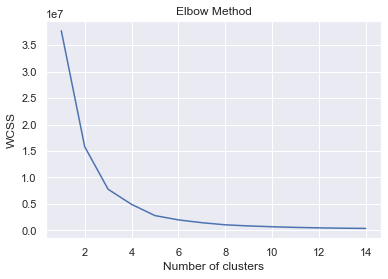

In [295]:
X = cluster_thresholds.iloc[:,0:5]
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

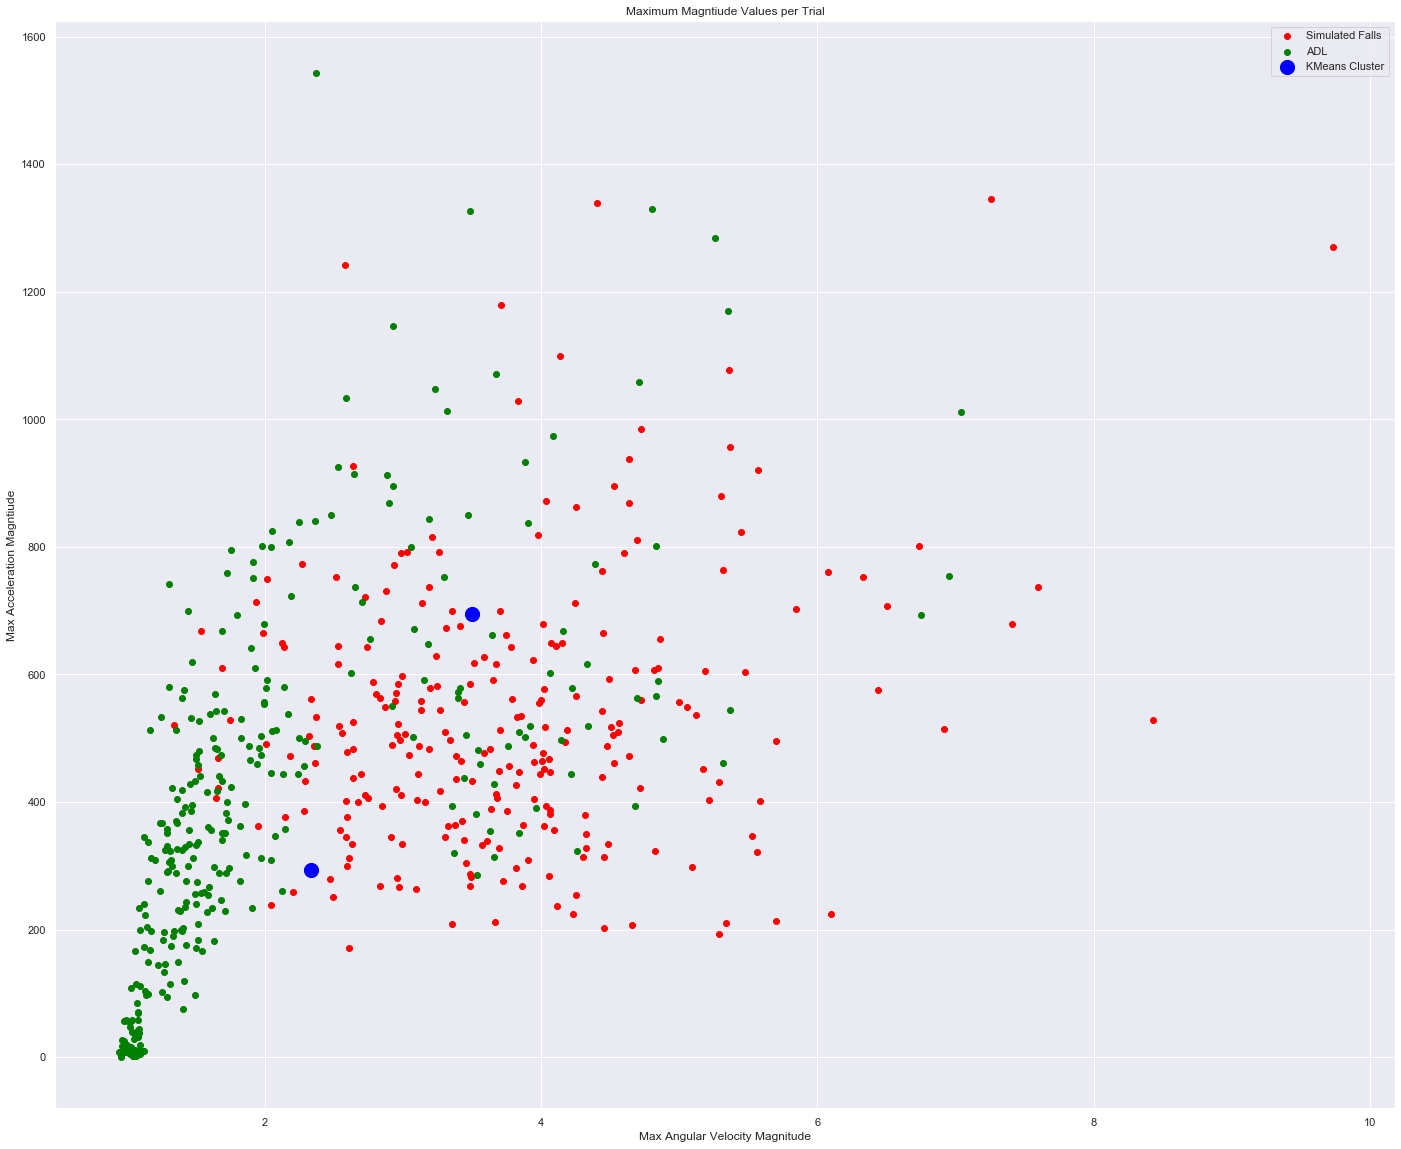

In [320]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
fig=plt.figure(figsize = (24,20))
plt.scatter(x=X.iloc[:,3][X['Activity']<6], y=X.iloc[:,4][X['Activity']<6], c="red", label='Simulated Falls')
plt.scatter(x=X.iloc[:,3][X['Activity']>5], y=X.iloc[:,4][X['Activity']>5], c="green", label="ADL")
plt.scatter(kmeans.cluster_centers_[:, 3], kmeans.cluster_centers_[:, 4], s=200, c='blue', label="KMeans Cluster")
plt.title("Maximum Magntiude Values per Trial")
plt.xlabel("Max Angular Velocity Magnitude")
plt.ylabel("Max Acceleration Magntiude")
plt.legend()
plt.show()

In [304]:
kmeans.cluster_centers_
# Fall cluster: 3.50 acceleration, 694.076 angular velocity
# ADL cluster: 2.33 acceleration, 292.689 angular velocity

array([[  9.34334764,   5.42918455,   1.98283262,   3.50222037,
        694.07635889],
       [  8.7607362 ,   6.37730061,   2.00920245,   2.33117836,
        292.68937724]])

### Test on Different Size Cluster
3 potential clusters indicated from elbow plot, 11 potential clusters for each experimental activity
* inconclusive results for both

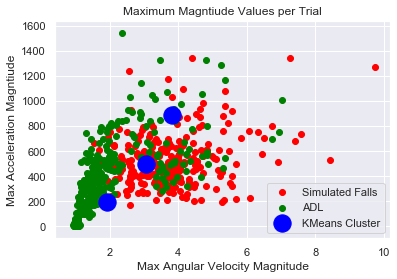

In [315]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(x=X.iloc[:,3][X['Activity']<6], y=X.iloc[:,4][X['Activity']<6], c="red", label='Simulated Falls')
plt.scatter(x=X.iloc[:,3][X['Activity']>5], y=X.iloc[:,4][X['Activity']>5], c="green", label="ADL")
plt.scatter(kmeans.cluster_centers_[:, 3], kmeans.cluster_centers_[:, 4], s=300, c='blue', label="KMeans Cluster")
plt.title("Maximum Magntiude Values per Trial")
plt.xlabel("Max Angular Velocity Magnitude")
plt.ylabel("Max Acceleration Magntiude")
plt.legend()
plt.show()

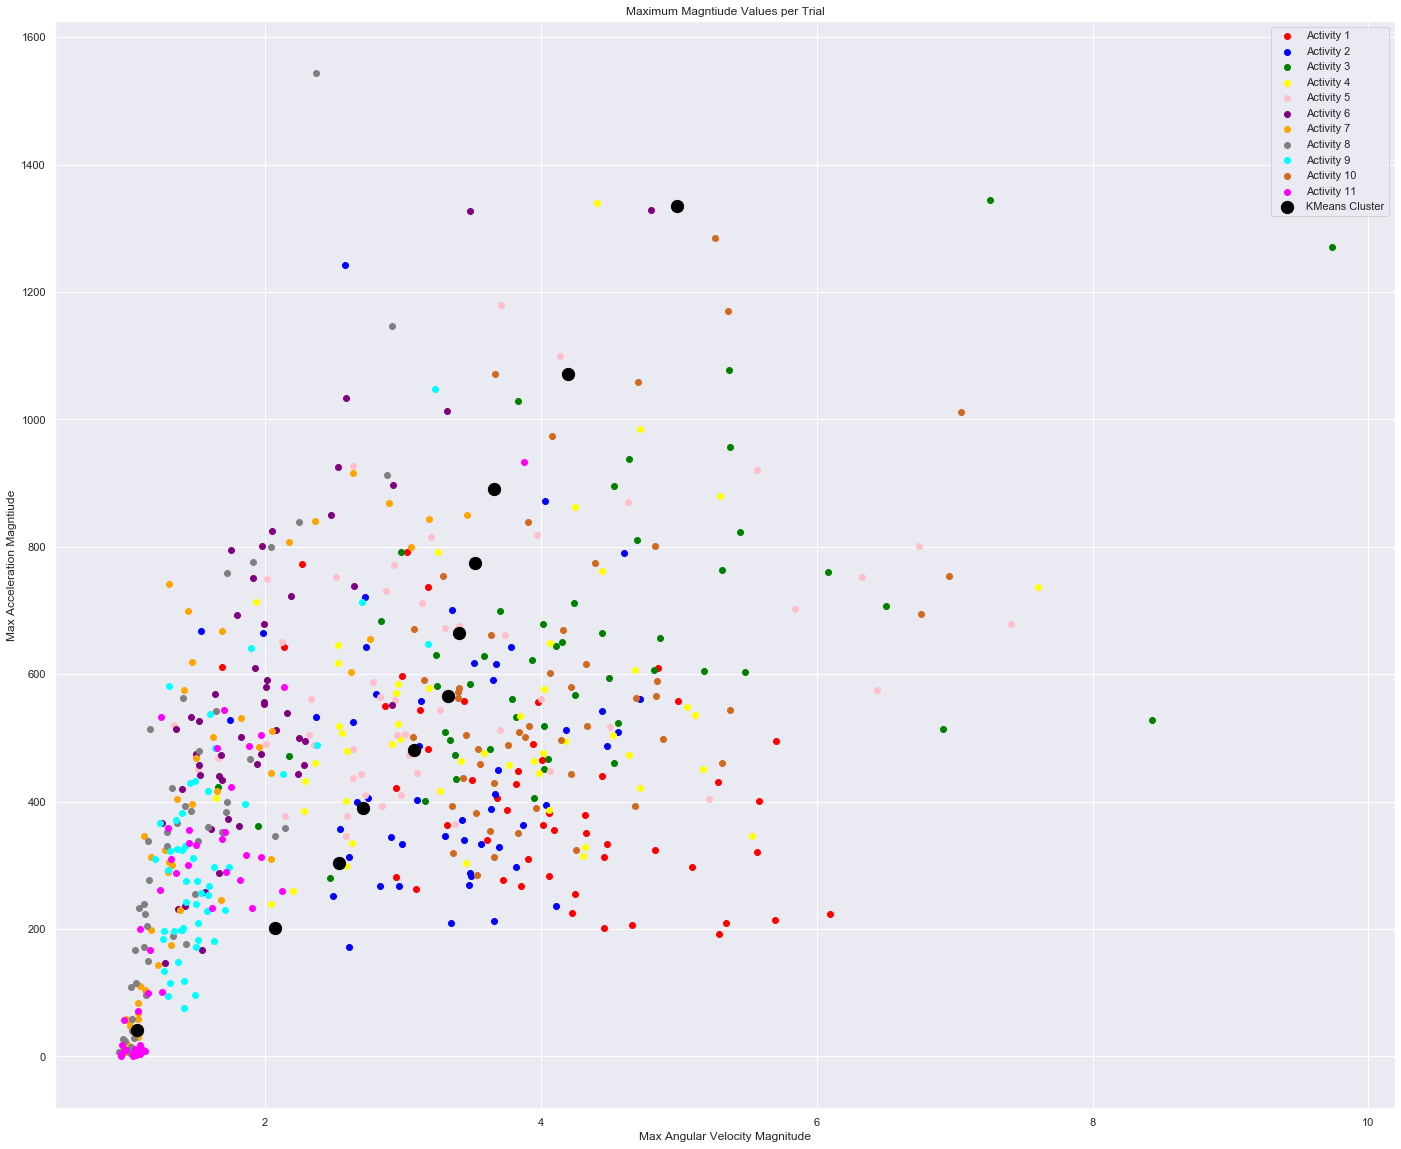

In [319]:
kmeans = KMeans(n_clusters=11, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
fig=plt.figure(figsize = (24,20))
plt.scatter(x=X.iloc[:,3][X['Activity']==1], y=X.iloc[:,4][X['Activity']==1], c="red", label='Activity 1')
plt.scatter(x=X.iloc[:,3][X['Activity']==2], y=X.iloc[:,4][X['Activity']==2], c="blue", label='Activity 2')
plt.scatter(x=X.iloc[:,3][X['Activity']==3], y=X.iloc[:,4][X['Activity']==3], c="green", label='Activity 3')
plt.scatter(x=X.iloc[:,3][X['Activity']==4], y=X.iloc[:,4][X['Activity']==4], c="yellow", label='Activity 4')
plt.scatter(x=X.iloc[:,3][X['Activity']==5], y=X.iloc[:,4][X['Activity']==5], c="pink", label='Activity 5')
plt.scatter(x=X.iloc[:,3][X['Activity']==6], y=X.iloc[:,4][X['Activity']==6], c="purple", label='Activity 6')
plt.scatter(x=X.iloc[:,3][X['Activity']==7], y=X.iloc[:,4][X['Activity']==7], c="orange", label='Activity 7')
plt.scatter(x=X.iloc[:,3][X['Activity']==8], y=X.iloc[:,4][X['Activity']==8], c="grey", label='Activity 8')
plt.scatter(x=X.iloc[:,3][X['Activity']==9], y=X.iloc[:,4][X['Activity']==9], c="cyan", label='Activity 9')
plt.scatter(x=X.iloc[:,3][X['Activity']==10], y=X.iloc[:,4][X['Activity']==10], c="chocolate", label='Activity 10')
plt.scatter(x=X.iloc[:,3][X['Activity']==11], y=X.iloc[:,4][X['Activity']==11], c="magenta", label='Activity 11')
plt.scatter(kmeans.cluster_centers_[:, 3], kmeans.cluster_centers_[:, 4], s=150, c='black', label="KMeans Cluster")
plt.title("Maximum Magntiude Values per Trial")
plt.xlabel("Max Angular Velocity Magnitude")
plt.ylabel("Max Acceleration Magntiude")
plt.legend()
plt.show()